In [93]:
import sys
import warnings
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.result import marginal_counts
from qiskit.providers.ibmq.job import job_monitor
from qiskit.tools.visualization import plot_histogram
import qiskit.quantum_info as qi
# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

In [94]:
# %matplotlib inline
# !pip install --quiet noisyopt
# !pip install --quiet numba --upgrade --user
# !pip install --quiet pennylane-sf --upgrade
from noisyopt import minimizeSPSA
import numpy as np
import itertools

(0) Load the dataset and process it likewise the classical method
======================

In [95]:
import classical

In [96]:
sequence_length = 5
x_train, y_train, x_val, y_val, x_test, y_test = \
    classical.get_data(sequence_length, n_stocks_train=1000, n_stocks_val=64)

100%|██████████| 1000/1000 [00:05<00:00, 196.91it/s]


Preprocessing Data


(1) First consider the case with only 1 feature (closed price). Normalize our feature x_1. 
======================
Our current data encoding method (from a floating point number to an angle), requires the floating number between (0,1]. So we need to first process the data using min-max normalization (like what we did to the volumn)


(2) Encode the normalized feature into an angle
======================

$$x_i` = \sqrt{(1-x_i^2)}$$
$$ angle \space \phi = \arctan{(x`_i/x_i)}$$

In [97]:
def get_open_only(x_data):
    return [x_datapoint[:, 3] for x_datapoint in x_data]
x_train = get_open_only(x_train)
x_val = get_open_only(x_val)
x_test = get_open_only(x_test)

In [98]:
print(x_test)

[array([-3.1315503 , -2.1947892 ,  1.2435393 , -0.60537726,  0.4447334 ],
      dtype=float32), array([-1.4355786 , -1.0054634 ,  1.4464233 ,  0.67382866, -0.31385085],
      dtype=float32), array([-0.7968674 ,  0.8769541 ,  0.08015199,  0.563164  , -0.08067413],
      dtype=float32), array([ 3.2210429, -2.2413082,  1.2032115, -3.1077511, -2.9586403],
      dtype=float32), array([-5.       , -4.653248 , -0.6964416, -2.62231  , -0.3327504],
      dtype=float32), array([-2.0500941 , -1.1382251 ,  1.5711751 , -1.7820092 ,  0.70592475],
      dtype=float32), array([-0.4892021 , -1.5434935 , -0.64563805, -2.0259109 ,  0.46378002],
      dtype=float32), array([-3.5440435 , -0.92806077,  0.5908147 ,  0.8690969 , -0.11472233],
      dtype=float32), array([-0.69631636,  0.40735066,  0.45060736, -0.9978766 ,  0.42472148],
      dtype=float32), array([-1.0775361 , -0.62396574,  0.29385796, -2.349857  ,  0.8984398 ],
      dtype=float32), array([-5.       , -2.819002 ,  0.8105886, -1.2346722,  1.3

In [99]:
print(len(y_train))

925


In [100]:
def contant_baseline():
  pred_value = 0
  for y in y_train:
    pred_value += y[-1]
  pred_value /= len(y_train)

  for name, test_set in ("train", y_train), ("Val", y_val), ("Test", y_test):
    losses = []
    for y in test_set:
        losses.append((y[-1] - pred_value) ** 2)
    print(f"{name} Loss: {sum(losses) / len(losses)}")
contant_baseline()

train Loss: 0.6142201519060917
Val Loss: 3.5540108373690384
Test Loss: 6.637646869843274


In [101]:
import tensorflow as tf
num_hidden = 64
model_tf = classical.make_lstm(sequence_length, 1, num_hidden)
train_tf = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_tf = tf.data.Dataset.from_tensor_slices((x_val, y_val))
model_tf = classical.train_model(model_tf, train_tf, val_tf)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
29/29 [==============================] - 3s 21ms/step - loss: 0.2591 - mse: 0.6358 - val_loss: 0.7658 - val_mse: 2.2748
Epoch 2/30
29/29 [==============================] - 0s 6ms/step - loss: 0.2489 - mse: 0.6043 - val_loss: 0.7382 - val_mse: 2.1820
Epoch 3/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2482 - mse: 0.6044 - val_loss: 0.7399 - val_mse: 2

In [102]:
test_tf = tf.data.Dataset.from_tensor_slices((x_test, y_test))
model_tf.evaluate(train_tf.batch(32))
model_tf.evaluate(val_tf.batch(32))
model_tf.evaluate(test_tf.batch(32))

2/2 [==============================] - 0s 3ms/step - loss: 0.9464 - mse: 3.1442


[0.946351170539856, 3.1442112922668457]

In [103]:
def float_to_angle(x):
    return classical.bounded_map(x) # send to -pi, pi

# Angles all have shape [batch, timesteps]
train_angles = np.array([float_to_angle(x) for x in x_train])
val_angles = np.array([float_to_angle(x) for x in x_val])
test_angles = np.array([float_to_angle(x) for x in x_test])    


train_angles_y = np.array([float_to_angle(y) for y in y_train])
val_angles_y = np.array([float_to_angle(y) for y in y_val])
test_angles_y = np.array([float_to_angle(y) for y in y_test])
assert np.all(-np.pi <= train_angles)
assert np.all(train_angles <= np.pi)

(3) Input the angle into Displacement gate
===========================
Input the angle into Displacement gate, to eventually integrate our features to the circuit. \
Reference of the Displacement gate: https://docs.pennylane.ai/en/stable/code/api/pennylane.Displacement.html \
Our current circuit is the one in "Rapid training of QRNN". Displacement gate is the D gate in the following figure. \
The I gate in the figure has been modeled by Luis into combination of basis gates (which can be found in the APIs in Pennylane). So we can first implement the circuit. Because Pennylane and Xanadu are proposed by the same company, we think that it will be smooth to run the code on Xanadu, after running on LocalSimulator.

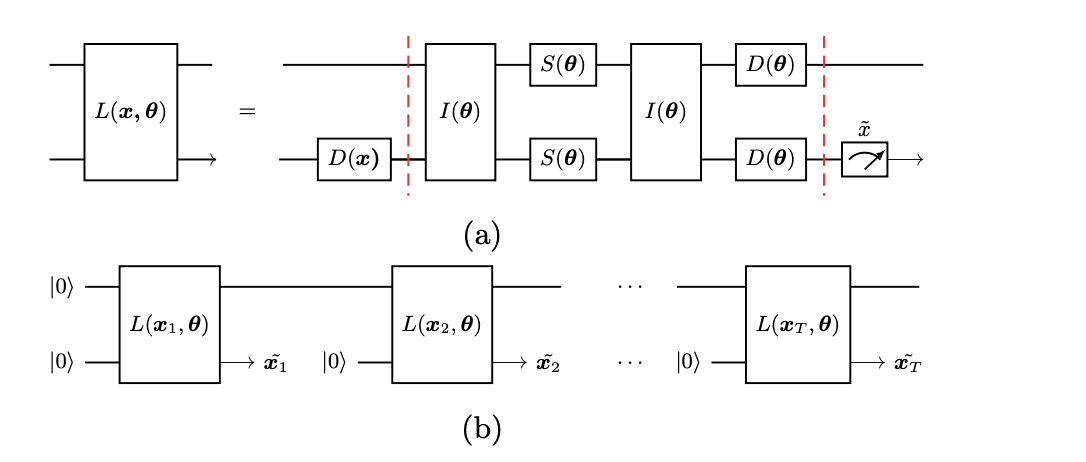

Variational classifiers usually define a "layer" or "block", which is an
elementary circuit architecture that gets repeated to build the
variational circuit.

Our circuit layer consists of an arbitrary rotation on every qubit, as
well as CNOTs that entangle each qubit with its neighbour.


In [104]:
depth = 1
q_wires = 2
combs = itertools.combinations(range(q_wires), 2)

def vqc_unit(params,qc,theta):
    # Encoding
    qc.u(theta,0,0,1)
    
    # qc.barrier()
    # Interaction
    for m in range(depth + 1):
        for i in range(q_wires):
            qc.u(params[m, i, 0], params[m, i, 1], params[m, i, 2],i)
        if m != depth:
            qc.cx(1,0)

shots = 100
backend = Aer.get_backend('aer_simulator')
# it's a multi-to-one Quantum RNN
def circuit_vqc(weights, theta):
    circuit = QuantumCircuit(q_wires,2)
    #print("len of theta: ", len(theta)) # which is == length of time series
    for i in range(len(theta)-1):
        vqc_unit(weights,circuit,theta[i])
        circuit.reset([1])

    vqc_unit(weights,circuit,theta[-1])   
    circuit.measure([1], [0])
    run_result = execute(circuit, backend=backend,shots=shots).result()
    # transpiled_circuit = transpile(circuit, backend)
    # run_result = backend.run(transpiled_circuit, shots=shots).result()

    simp_counts0 = marginal_counts(run_result, indices=[0]).get_counts()

    # label y -> theta_y, so prediction = 2 cos^-1(amplitude of |0>)? 
    num_ones = simp_counts0['1'] if '1' in simp_counts0 else 0
    # Multiply by slightly less than pi so we don't ever predict infinity
    return np.tan((num_ones/shots - .5) * 2.75)


In [105]:
np.random.seed(2)
num_qubits = 2
num_layers = 1
n_wires = 2
weights_init_qaoa = 2 * np.pi * np.random.randn(depth + 1, n_wires, 3)
# weights_init_2_37 = [[[7.61374852,  22.78989675,  -5.05269721],  [11.73029474, -34.41191977,
#   -0.62629259]],  [[16.80420492, -23.27697199, -16.3814021],  [-25.9409255,
#   21.83145357,  -6.12175864]]]
# weights_init_qaoa = np.array(weights_init_2_37)

In [106]:
def square_loss(labels, predictions):
    loss = []
    for l, p in zip(labels, predictions):
      l = classical.inv_bounded_map(l)
      loss.append((l - p) ** 2)
    loss = np.mean(loss)
    return loss

In [107]:
# https://pennylane.ai/qml/demos/spsa.html
# in our temporal experiment, we select 50 stocks
# each stock has 10 data points
train_costs = []
val_costs = []
cur_weights = weights_init_qaoa.flatten().copy()
iteration_num = 0
val_freq = 5
best_val = 100
batch_size = 16
best_val_w = cur_weights
def cost_spsa(weights, seed=0):
    np.random.seed(seed)
    batch_inds = np.random.randint(train_angles.shape[0], size=batch_size)
    
    # X contains a time series of every stock
    X = train_angles[batch_inds, :]
    weights = weights.reshape(weights_init_qaoa.shape)
    predictions = [circuit_vqc(weights, x) for x in X] 
    loss = square_loss(train_angles_y[batch_inds, -1], predictions)
    train_costs.append(loss)
    return loss

def val_cost(weights, X=val_angles, y=val_angles_y):
  weights = weights.reshape(weights_init_qaoa.shape)
  predictions = [circuit_vqc(weights, x) for x in X] 
  return square_loss(y[:, -1], predictions)

def callback_fn(w):
    global iteration_num, best_val

    iteration_num += 1
    if (iteration_num - 1) % val_freq == 0:
      val_loss = val_cost(w)
      val_costs.append(val_loss)

      print(
          f"Iteration = {iteration_num}, "
          f"Val Loss = {val_loss} "
          f"Train Loss = {np.mean(train_costs[-val_freq:-1])}"
      )
      if val_loss < best_val:
        best_val_w = w
        best_val = val_loss
        print("Update best val w")

In [108]:
res = minimizeSPSA(
    cost_spsa,
    x0=cur_weights,
    niter=60,
    paired=True,
    c=0.01,
    a=0.003,
    callback=callback_fn,
)
cur_weights = res.x

Iteration = 1, Val Loss = 2.5448144865699254 Train Loss = 1.488883429646345
Update best val w
Iteration = 6, Val Loss = 2.5728742995878453 Train Loss = 3.4289161410351494
Iteration = 11, Val Loss = 2.78226797528452 Train Loss = 1.1568942700437956
Iteration = 16, Val Loss = 2.681171731177304 Train Loss = 0.7651734918535296
Iteration = 21, Val Loss = 2.793173172656052 Train Loss = 1.4442233478048048
Iteration = 26, Val Loss = 2.7382520553422487 Train Loss = 1.972612280375382
Iteration = 31, Val Loss = 2.828415346327471 Train Loss = 1.2466075183909715


In [ ]:
print(repr(best_val_w))

array([ -2.61856678,  -0.3535349 , -13.42211592,  10.30612544,
       -11.26848812,  -5.28885468,   3.15969713,  -7.82437581,
        -6.64730984,  -5.71146329,   3.46488795,  14.40236771])


Run 1: Cost Val 2.561927900398338 Test 4.783516535821272
Run 2: Cost Val 2.6787928916674875 Test 4.869681240767217
Run 3: Cost Val 2.7165789575378345 Test 4.753428540705295


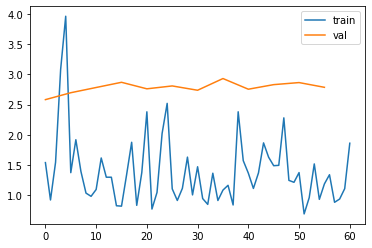

In [ ]:
import matplotlib.pyplot as plt
# Run 3 times because it will be different each time due to randomness...
print(f"Run 1: Cost Val {val_cost(best_val_w, val_angles, val_angles_y)} Test {val_cost(best_val_w, test_angles, test_angles_y)}")
print(f"Run 2: Cost Val {val_cost(best_val_w, val_angles, val_angles_y)} Test {val_cost(best_val_w, test_angles, test_angles_y)}")
print(f"Run 3: Cost Val {val_cost(best_val_w, val_angles, val_angles_y)} Test {val_cost(best_val_w, test_angles, test_angles_y)}")
plt.plot(train_costs[::2], label='train')
plt.plot(range(0, len(val_costs) * val_freq, val_freq), val_costs, label='val')
plt.legend()
plt.show()

end
==============